In [2]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import pandas as pd
import numpy as np
import struct

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier 

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, train_test_split

from hyperopt import fmin, tpe, hp
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt

from copy import deepcopy as copy

%matplotlib inline

# RF regressor optimization code

In [4]:
def bayesian_optimization_lightgbm(X, y, cv=6, max_iter_opt=15):
    svr_opt = BayesianOptimization(
        lambda feature_fraction, bagging_freq, bagging_fraction, n_estimators: cross_val_score(
            LGBMClassifier(
                boosting_type='rf', 
                feature_fraction=feature_fraction, 
                bagging_freq=int(bagging_freq), 
                bagging_fraction=bagging_fraction,
                n_estimators=int(n_estimators)
            ),
            X, y.squeeze(), cv=KFold(n_splits=cv).split(X), scoring='accuracy'
        ).mean(),
        {'feature_fraction': (0.05, 0.95),
         'bagging_fraction': (0.05, 0.95),
         'bagging_freq': (1, 50),
         'n_estimators': (5, 50) },
        verbose=0
    )
    
    svr_opt.init(10)
    svr_opt.maximize(n_iter=max_iter_opt)
    
    return svr_opt.res['max']['max_params']#['C']

# MNIST

In [48]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

In [49]:
X = read_idx('../datasets/mnist/train-images.idx3-ubyte')
y = read_idx('../datasets/mnist/train-labels.idx1-ubyte')

In [50]:
X = X / np.max(X)

In [51]:
X = X.reshape(X.shape[0], -1)

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [53]:
print('dataset size: {}'.format(X.shape))

dataset size: (60000, 784)


### Training model with PCA-processed data

In [11]:
# number of components is fixed to 10
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [12]:
X_pca, y_train = shuffle(X_pca, y_train)

### * Estimating LightGBM params

In [13]:
params_opt = bayesian_optimization_lightgbm(X, y, cv=4, max_iter_opt=10)

In [14]:
params_opt['bagging_freq'] = int(params_opt['bagging_freq'])
params_opt['n_estimators'] = int(params_opt['n_estimators'])

In [56]:
models = {
    'rf': LGBMClassifier(boosting_type='rf', **params_opt),
    'lr': LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear', C=10000, tol=1e-2),
    'svc': LinearSVC(multi_class='ovr', C=10000, tol=1e-2),
}

### * Evaluate with CV

In [57]:
stats = {}

for n_components in range(1, 11):
    print('n_components: {}'.format(n_components))
    stats[n_components] = {'cv': dict(), 'val': dict()}
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    
    for k, model in models.items():
        stats[n_components]['cv'][k] = []
        kfold = KFold(n_splits=4, shuffle=True, random_state=42)
        
        for train_ix, test_ix in kfold.split(X_pca, y_train):
            _model = copy(model)
            
            X_crossval_train, X_crossval_test = X_pca[train_ix], X_pca[test_ix]
            y_crossval_train, y_crossval_test = y_train[train_ix], y_train[test_ix]

            # here must be sume sort of optimization
            _model.fit(X_crossval_train, y_crossval_train.ravel())
            stats[n_components]['cv'][k].append(accuracy_score(_model.predict(X_crossval_test), y_crossval_test, normalize=True))
        print('- cv for ' + k + ' is ready')
    
    for name, model in models.items():
        _model = copy(model)
        _model.fit(X_pca, y_train.squeeze())
        stats[n_components]['val'][name] = accuracy_score(_model.predict(X_val_pca), y_val.squeeze())

n_components: 1
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 2
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 3
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 4
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 5
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 6
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 7
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 8
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 9
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 10
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready


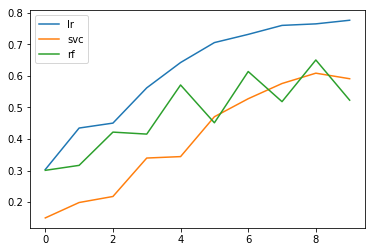

In [58]:
_classifiers = []

for n_components, _stats in stats.items():
    lr_cv = np.mean(_stats['cv']['lr'])
    svm_cv = np.mean(_stats['cv']['svc'])
    rf_cv = np.mean(_stats['cv']['rf'])
    
    _classifiers.append([lr_cv, svm_cv, rf_cv])
    
pd.DataFrame(_classifiers, columns = ['lr', 'svc', 'rf']).plot()

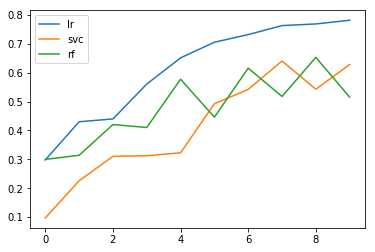

In [59]:
_classifiers = []

for n_components, _stats in stats.items():
    lr_cv = np.mean(_stats['val']['lr'])
    svm_cv = np.mean(_stats['val']['svc'])
    rf_cv = np.mean(_stats['val']['rf'])
    
    _classifiers.append([lr_cv, svm_cv, rf_cv])
    
pd.DataFrame(_classifiers, columns = ['lr', 'svc', 'rf']).plot()

# Credit Card Fraud

In [62]:
df = pd.read_csv('../datasets/creditcard/creditcard.csv')

In [63]:
X = df[np.setdiff1d(df.columns, ["Class", "Time"])].values
y = df.Class.values

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [65]:
print('dataset size: {}'.format(X.shape))

dataset size: (284807, 29)


### Training model with PCA-processed data

In [66]:
# number of components is fixed to 10
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [67]:
X_pca, y_train = shuffle(X_pca, y_train)

### * Estimating LightGBM params

In [68]:
params_opt = bayesian_optimization_lightgbm(X_pca, y_train, cv=4, max_iter_opt=10)

In [69]:
params_opt['bagging_freq'] = int(params_opt['bagging_freq'])
params_opt['n_estimators'] = int(params_opt['n_estimators'])

In [70]:
models = {
    'rf': LGBMClassifier(boosting_type='rf', **params_opt),
    'lr': LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear', C=10000, tol=1e-2),
    'svc': LinearSVC(multi_class='ovr', C=10000, tol=1e-2),
}

In [71]:
stats = {}

for n_components in range(1, 11):
    print('n_components: {}'.format(n_components))
    stats[n_components] = {'cv': dict(), 'val': dict()}
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    
    for k, model in models.items():
        stats[n_components]['cv'][k] = []
        kfold = KFold(n_splits=4, shuffle=True, random_state=42)
        
        for train_ix, test_ix in kfold.split(X_pca, y_train):
            _model = copy(model)
            
            X_crossval_train, X_crossval_test = X_pca[train_ix], X_pca[test_ix]
            y_crossval_train, y_crossval_test = y_train[train_ix], y_train[test_ix]

            # here must be sume sort of optimization
            _model.fit(X_crossval_train, y_crossval_train.ravel())
            stats[n_components]['cv'][k].append(accuracy_score(_model.predict(X_crossval_test), y_crossval_test, normalize=True))
        print('- cv for ' + k + ' is ready')
    
    for name, model in models.items():
        _model = copy(model)
        _model.fit(X_pca, y_train.squeeze())
        stats[n_components]['val'][name] = accuracy_score(_model.predict(X_val_pca), y_val.squeeze())

n_components: 1
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 2
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 3
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 4
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 5
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 6
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 7
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 8
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 9
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 10
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready


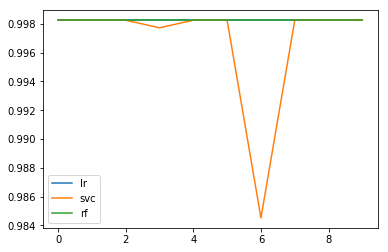

In [72]:
_classifiers = []

for n_components, _stats in stats.items():
    lr_cv = np.mean(_stats['cv']['lr'])
    svm_cv = np.mean(_stats['cv']['svc'])
    rf_cv = np.mean(_stats['cv']['rf'])
    
    _classifiers.append([lr_cv, svm_cv, rf_cv])
    
pd.DataFrame(_classifiers, columns = ['lr', 'svc', 'rf']).plot()

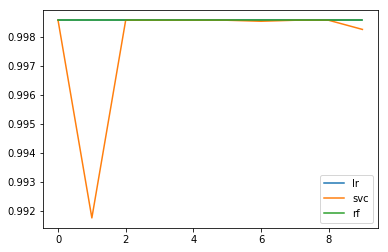

In [73]:
_classifiers = []

for n_components, _stats in stats.items():
    lr_cv = np.mean(_stats['val']['lr'])
    svm_cv = np.mean(_stats['val']['svc'])
    rf_cv = np.mean(_stats['val']['rf'])
    
    _classifiers.append([lr_cv, svm_cv, rf_cv])
    
pd.DataFrame(_classifiers, columns = ['lr', 'svc', 'rf']).plot()

# Breast Cancer

In [75]:
df = pd.read_csv('../datasets/cancer/breast_cancer.csv')
y = df.diagnosis.replace('M', 0).replace('B', 1).values
X = np.asarray(df.drop(['diagnosis', 'id', 'Unnamed: 32'], axis=1).as_matrix())

In [76]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [77]:
print('dataset size: {}'.format(X.shape))

dataset size: (569, 30)


### Training model with PCA-processed data

In [78]:
# number of components is fixed to 10
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [79]:
X_pca, y_train = shuffle(X_pca, y_train)

### * Estimating LightGBM params

In [80]:
params_opt = bayesian_optimization_lightgbm(X_pca, y_train, cv=4, max_iter_opt=10)

In [81]:
params_opt['bagging_freq'] = int(params_opt['bagging_freq'])
params_opt['n_estimators'] = int(params_opt['n_estimators'])

In [86]:
models = {
    'rf': LGBMClassifier(boosting_type='rf', **params_opt),
    'lr': LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear', C=10000, tol=1e-2),
    'svc': LinearSVC(multi_class='ovr', C=10000),
}

In [90]:
stats = {}

for n_components in range(1, 25):
    print('n_components: {}'.format(n_components))
    stats[n_components] = {'cv': dict(), 'val': dict()}
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    
    for k, model in models.items():
        stats[n_components]['cv'][k] = []
        kfold = KFold(n_splits=4, shuffle=True, random_state=42)
        
        for train_ix, test_ix in kfold.split(X_pca, y_train):
            _model = copy(model)
            
            X_crossval_train, X_crossval_test = X_pca[train_ix], X_pca[test_ix]
            y_crossval_train, y_crossval_test = y_train[train_ix], y_train[test_ix]

            # here must be sume sort of optimization
            _model.fit(X_crossval_train, y_crossval_train.ravel())
            stats[n_components]['cv'][k].append(accuracy_score(_model.predict(X_crossval_test), y_crossval_test, normalize=True))
        print('- cv for ' + k + ' is ready')
    
    for name, model in models.items():
        _model = copy(model)
        _model.fit(X_pca, y_train.squeeze())
        stats[n_components]['val'][name] = accuracy_score(_model.predict(X_val_pca), y_val.squeeze())

n_components: 1
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 2
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 3
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 4
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 5
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 6
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 7
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 8
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 9
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 10
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 11
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 12
- cv for rf is ready
- cv for lr is ready
- cv for svc is ready
n_components: 13
- cv for rf is ready

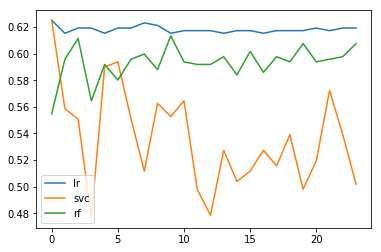

In [91]:
_classifiers = []

for n_components, _stats in stats.items():
    lr_cv = np.mean(_stats['cv']['lr'])
    svm_cv = np.mean(_stats['cv']['svc'])
    rf_cv = np.mean(_stats['cv']['rf'])
    
    _classifiers.append([lr_cv, svm_cv, rf_cv])
    
pd.DataFrame(_classifiers, columns = ['lr', 'svc', 'rf']).plot()

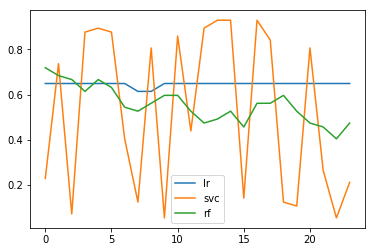

In [92]:
_classifiers = []

for n_components, _stats in stats.items():
    lr_cv = np.mean(_stats['val']['lr'])
    svm_cv = np.mean(_stats['val']['svc'])
    rf_cv = np.mean(_stats['val']['rf'])
    
    _classifiers.append([lr_cv, svm_cv, rf_cv])
    
pd.DataFrame(_classifiers, columns = ['lr', 'svc', 'rf']).plot()